# Imports

In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import sklearn
import sklearn.model_selection
from tensorflow import keras
from tensorflow.keras import layers
import shap
from scipy.stats import wilcoxon


# Download dataset

In [3]:
import pathlib

dir_base = '/home/'
dataset_url = "https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/wtp4ssmwsd-1.zip"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname= dir_base + 'traffic_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

In [4]:
import zipfile
with zipfile.ZipFile(dir_base + 'traffic_photos.tar.gz', 'r') as zip_ref:
    zip_ref.extractall(dir_base)
with zipfile.ZipFile(dir_base + 'obj.zip', 'r') as zip_ref:
    zip_ref.extractall(dir_base)

dir_img = dir_base + 'obj/' 

# Read classification

In [5]:
from os import listdir
from os.path import isfile, join
onlyfilestxt = [f for f in listdir(dir_img) if isfile(join(dir_img, f)) and f.endswith('.txt')]

In [6]:
len(onlyfilestxt)

4234

In [7]:
dir_img_only = dir_img + 'images/'
if not os.path.exists(dir_img_only):
    os.mkdir(dir_img_only)
    os.mkdir(dir_img_only + 'traffic/')
    os.mkdir(dir_img_only + 'no_traffic/')


In [8]:
for filename in onlyfilestxt:
  with open(dir_img + filename) as f:
    lines = f.readlines()
    img_filename = filename[:-4] + '.jpg'

    if len(lines)>0 and len(lines[0])>0:
      # Traffic
      if lines[0][0] == '0':
        os.rename(dir_img + img_filename, dir_img_only + 'traffic/' + img_filename)
      # No traffic
      else:
        os.rename(dir_img + img_filename, dir_img_only + 'no_traffic/' + img_filename)

  os.remove(dir_img + filename)

In [9]:
onlyfiles_no_traffic = [f for f in listdir(dir_img_only + 'no_traffic/') if isfile(join(dir_img_only + 'no_traffic/', f))]
onlyfiles_traffic = [f for f in listdir(dir_img_only + 'traffic/') if isfile(join(dir_img_only + 'traffic/', f))]

print(len(onlyfiles_no_traffic))
print(len(onlyfiles_traffic))

2063
2169


# Read images
https://machinelearningmastery.com/image-augmentation-deep-learning-keras/

In [10]:
IMAGE_SIZE = 32
BATCH_SIZE = 64

# Data augmentation
datagen = ImageDataGenerator(rescale=(1/255)#,
    #rotation_range=40,  #Rota imagenes aleatoriamente en un rango de 40º [-40 - 40]
    #width_shift_range=0.2,  #Desplaza imagenes aleatoriamente
    #height_shift_range=0.2, #Desplaza imagenes aleatoriamente
    #shear_range=0.2,  #Recorta imagenes aleatoriamente
    #zoom_range=0.2, #Zoom en imagenes aleatoriamente
    #horizontal_flip=True,
    #fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
  dir_img_only,
  target_size=(IMAGE_SIZE, IMAGE_SIZE),
  #batch_size=BATCH_SIZE,
  batch_size=-1, #Falta comprobar
  #subset='training',
  shuffle = False,
  class_mode = 'binary',
  classes = ['no_traffic','traffic']
)

Found 4232 images belonging to 2 classes.


# Show images

In [11]:
def plot_symbols(X,y,n=15):
    index = np.random.randint(len(y), size=n)
    plt.figure(figsize=(25, 2))
    for i in np.arange(n):
        ax = plt.subplot(1,n,i+1)
        plt.imshow(X[index[i],:,:,:])
        plt.gray()
        ax.set_title(f'{y[index[i]]}-{index[i]}')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

def plot_image(X,y,index=0):
    plt.figure(figsize=(25, 2))
    ax = plt.subplot(1,1,1)
    plt.imshow(X[index])
    plt.gray()
    ax.set_title(f'{y[index]}-{index}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

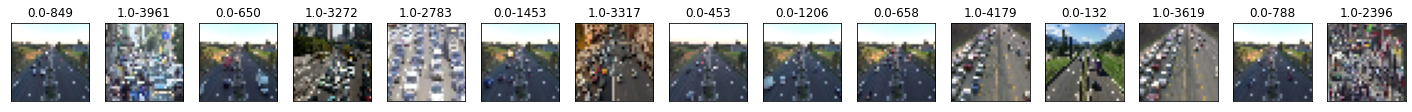

In [12]:
X,y = train_generator.next()
plot_symbols(X, y, 15)

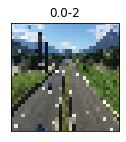

In [13]:
plot_image(X,y,2)

# Data augmentation

In [14]:
def data_augmentation(X_train,y_train,batch_size):
  image_gen=ImageDataGenerator(
    rotation_range=40,  #Rota imagenes aleatoriamente en un rango de 40º [-40 - 40]
    width_shift_range=0.2,  #Desplaza imagenes aleatoriamente
    height_shift_range=0.2, #Desplaza imagenes aleatoriamente
    shear_range=0.2,  #Recorta imagenes aleatoriamente
    zoom_range=0.2, #Zoom en imagenes aleatoriamente
    horizontal_flip=True,
    fill_mode='nearest')

  data_augmented=image_gen.flow(X_train, y_train, batch_size=batch_size,seed=1)

  return data_augmented

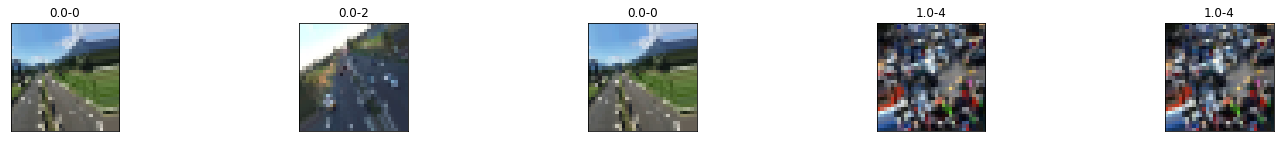

In [15]:
it = data_augmentation(X,y,5)
batch = it.next()

plot_symbols(batch[0], batch[1], 5)

# Split data

In [16]:
n_cross_val = 10
skf=sklearn.model_selection.StratifiedKFold(n_splits=n_cross_val,random_state=1,shuffle=True)


# Models

In [17]:
import tensorflow_hub as hub

def cnn_model():
  #Descargamos el modelo
  URL = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4'
  feature_extractor =  hub.KerasLayer(
      URL,
      input_shape=X[0].shape
  )

  #Bloqueamos el entrenamiento de los pesos ya entrenados de esta red
  feature_extractor.trainable=False

  #Adaptamos la red a nuestras necesidades
  model = tf.keras.models.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(1,activation='sigmoid')
  ])

  return model

In [18]:
def cnn_model2():
  visible = layers.Input(shape=X[0].shape)
  x = layers.Conv2D(16,(3,3),padding="same",activation="relu")(visible)
  x = layers.MaxPooling2D((2,2))(x)

  x = layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
  x = layers.MaxPooling2D((2,2))(x)

  x = layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
  x = layers.MaxPooling2D((2,2))(x)

  x = layers.Flatten()(x)

  x = layers.Dense(512,activation="relu")(x)
  
  x = layers.Dense(256,activation="relu")(x)
  
  x = layers.Dense(64,activation="relu")(x)

  x = layers.Dense(32,activation="relu")(x)

  output = layers.Dense(1, activation='sigmoid')(x)

  model = keras.Model(inputs=visible, outputs=output)

  return model

In [19]:
def cnn_model3():
  visible = layers.Input(shape=X[0].shape)
  x = layers.Conv2D(16,(3,3),padding="same",activation="relu")(visible)
  x = layers.MaxPooling2D((2,2))(x)

  x = layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
  x = layers.MaxPooling2D((2,2))(x)

  x = layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
  x = layers.MaxPooling2D((2,2))(x)

  x = layers.Flatten()(x)

  x = layers.Dense(512,activation="relu")(x)
  x = layers.Dropout(0.1)(x)
  
  x = layers.Dense(256,activation="relu")(x)
  x = layers.Dropout(0.1)(x)
  
  x = layers.Dense(64,activation="relu")(x)
  x = layers.Dropout(0.1)(x)

  x = layers.Dense(32,activation="relu")(x)

  output = layers.Dense(1, activation='sigmoid')(x)

  model = keras.Model(inputs=visible, outputs=output)

  return model

# Training

In [20]:
epochs = 500

cvscores=[]
y_cvscores=[]
cvy_test=[]
cvy_train=[]
i=0

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

for train_index,test_index in skf.split(X,y):#nuevo
#for train_index,test_index in skf.split(train_generator):#nuevo
  print(f'Folder: {i}')
  i+=1
  model = cnn_model2()

  X_train,X_test=X[train_index],X[test_index]#nuevo Falta cambiar
  y_train_nn,y_test_nn=y[train_index],y[test_index]#nuevo Falta cambiar
  y_train,y_test=y[train_index],y[test_index] #Falta cambiar

  data_augmented=data_augmentation(X_train,y_train_nn,32) #Aumentado de datos

  cvy_test.append(y_test)
  cvy_train.append(y_train)

  model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
  history=model.fit(data_augmented, batch_size=BATCH_SIZE, epochs=epochs, validation_data=(X_test,y_test_nn), verbose=2, callbacks=[early_stopping]) #Aumentado de datos


  scores =model.evaluate(X_test,y_test_nn,verbose=0)
  y_scores=model.predict(X_test) # Confidence prediction per class
  cvscores.append(scores)
  y_cvscores.append(y_scores)
  #print("%s: %.2f%%"%(model.metrics_names[1],scores[1]*100))
  #Borrar:
  #if i==2:
  #  break

print(model.summary())

Folder: 0
Epoch 1/500
119/119 - 5s - loss: 0.3872 - accuracy: 0.8353 - val_loss: 0.4769 - val_accuracy: 0.7854 - 5s/epoch - 43ms/step
Epoch 2/500
119/119 - 2s - loss: 0.3022 - accuracy: 0.8839 - val_loss: 0.4794 - val_accuracy: 0.8042 - 2s/epoch - 16ms/step
Epoch 3/500
119/119 - 2s - loss: 0.2579 - accuracy: 0.8976 - val_loss: 0.2342 - val_accuracy: 0.9151 - 2s/epoch - 16ms/step
Epoch 4/500
119/119 - 2s - loss: 0.2398 - accuracy: 0.9041 - val_loss: 0.3753 - val_accuracy: 0.8915 - 2s/epoch - 16ms/step
Epoch 5/500
119/119 - 2s - loss: 0.2106 - accuracy: 0.9136 - val_loss: 0.2872 - val_accuracy: 0.9127 - 2s/epoch - 16ms/step
Epoch 6/500
119/119 - 2s - loss: 0.2019 - accuracy: 0.9204 - val_loss: 0.5097 - val_accuracy: 0.8184 - 2s/epoch - 16ms/step
Epoch 7/500
119/119 - 2s - loss: 0.1778 - accuracy: 0.9312 - val_loss: 0.2571 - val_accuracy: 0.9245 - 2s/epoch - 16ms/step
Epoch 8/500
119/119 - 2s - loss: 0.1778 - accuracy: 0.9328 - val_loss: 0.3534 - val_accuracy: 0.8844 - 2s/epoch - 16ms/ste

In [21]:

cv_loss = []
cv_acc = []
loss=0
acc=0
for i in range(len(cvscores)):
  i_loss, i_acc = cvscores[i]
  cv_loss.append(i_loss)
  cv_acc.append(i_acc)
  
  loss+=i_loss
  acc+=i_acc
loss/=len(cvscores)
acc/=len(cvscores)
acc0=cv_acc
print(f'loss: {loss:.2f} acc: {acc:.2f}')

loss: 0.19 acc: 0.94


##Evaluación overfitting

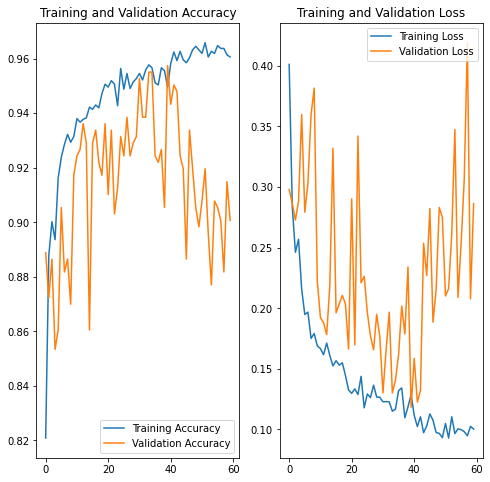

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(epochs)
epochs_range = range(len(loss))

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.savefig('./foo.png')
plt.show()

# AUC

In [23]:
from sklearn import metrics

cv_auc0=[]
auc0=0
#y_cvscores = predicciones
#cvy_test = soluciones

for i in range(len(y_cvscores)):
  y_pred = y_cvscores[i].argmax(axis=1) # Select classes with most confidence prediction
  auc_i=metrics.roc_auc_score(cvy_test[i], np.round(y_cvscores[i][:,0],2))
  auc0+=auc_i

  cv_auc0.append(auc_i)

auc0/=len(cv_auc0)
print(cv_auc0)
print(f'AUC {auc0:.4f} ')

[0.9955030165408847, 0.9894211844694937, 0.9912886920737162, 0.9926177799651021, 0.9904142991365039, 0.9895865956780457, 0.9633461590085455, 0.99121963223122, 0.9950449644311217, 0.9900451881347591]
AUC 0.9888 


# SHAP

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


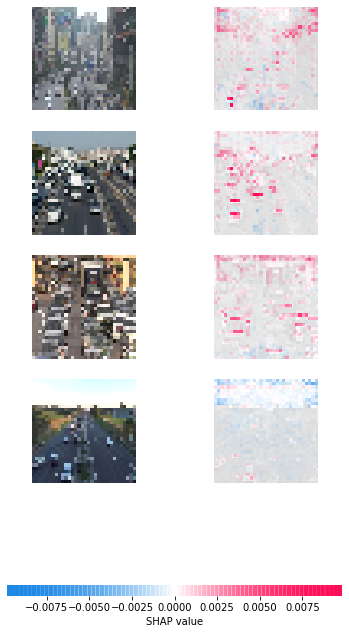

In [24]:
# select a set of background examples to take an expectation over
background = X[np.random.choice(X.shape[0], 100, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(background[1:5])

# plot the feature attributions
shap.image_plot(shap_values, background[1:5])

# Otro modelo

In [25]:
epochs = 500

cvscores=[]
y_cvscores=[]
cvy_test=[]
cvy_train=[]
i=0

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

for train_index,test_index in skf.split(X,y):#nuevo
#for train_index,test_index in skf.split(train_generator):#nuevo
  print(f'Folder: {i}')
  i+=1
  model = cnn_model()

  X_train,X_test=X[train_index],X[test_index]#nuevo Falta cambiar
  y_train_nn,y_test_nn=y[train_index],y[test_index]#nuevo Falta cambiar
  y_train,y_test=y[train_index],y[test_index] #Falta cambiar

  data_augmented=data_augmentation(X_train,y_train_nn,32) #Aumentado de datos

  cvy_test.append(y_test)
  cvy_train.append(y_train)

  model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
  history=model.fit(data_augmented, batch_size=BATCH_SIZE, epochs=epochs, validation_data=(X_test,y_test_nn), verbose=2, callbacks=[early_stopping]) #Aumentado de datos


  scores =model.evaluate(X_test,y_test_nn,verbose=0)
  y_scores=model.predict(X_test) # Confidence prediction per class
  cvscores.append(scores)
  y_cvscores.append(y_scores)
  #print("%s: %.2f%%"%(model.metrics_names[1],scores[1]*100))
  #Borrar:
  #if i==2:
  #  break

print(model.summary())

Folder: 0
Epoch 1/500
119/119 - 8s - loss: 0.5417 - accuracy: 0.7536 - val_loss: 0.3999 - val_accuracy: 0.8632 - 8s/epoch - 70ms/step
Epoch 2/500
119/119 - 3s - loss: 0.4296 - accuracy: 0.8303 - val_loss: 0.3382 - val_accuracy: 0.8774 - 3s/epoch - 21ms/step
Epoch 3/500
119/119 - 2s - loss: 0.3824 - accuracy: 0.8498 - val_loss: 0.3080 - val_accuracy: 0.8797 - 2s/epoch - 21ms/step
Epoch 4/500
119/119 - 3s - loss: 0.3696 - accuracy: 0.8471 - val_loss: 0.2949 - val_accuracy: 0.8821 - 3s/epoch - 21ms/step
Epoch 5/500
119/119 - 2s - loss: 0.3641 - accuracy: 0.8505 - val_loss: 0.2811 - val_accuracy: 0.8892 - 2s/epoch - 21ms/step
Epoch 6/500
119/119 - 2s - loss: 0.3393 - accuracy: 0.8600 - val_loss: 0.2737 - val_accuracy: 0.8915 - 2s/epoch - 21ms/step
Epoch 7/500
119/119 - 3s - loss: 0.3398 - accuracy: 0.8663 - val_loss: 0.2698 - val_accuracy: 0.8962 - 3s/epoch - 21ms/step
Epoch 8/500
119/119 - 2s - loss: 0.3393 - accuracy: 0.8666 - val_loss: 0.2653 - val_accuracy: 0.8962 - 2s/epoch - 21ms/ste

In [26]:
cv_auc1=[]
auc1=0
#y_cvscores = predicciones
#cvy_test = soluciones

for i in range(len(y_cvscores)):
  y_pred = y_cvscores[i].argmax(axis=1) # Select classes with most confidence prediction
  auc_i=metrics.roc_auc_score(cvy_test[i], np.round(y_cvscores[i][:,0],2))
  auc1+=auc_i

  cv_auc1.append(auc_i)

auc1/=len(cv_auc1)
print(cv_auc1)
print(f'AUC {auc1:.4f} ')

[0.9626661323716021, 0.9483024691358025, 0.9627169439971373, 0.9697328978569192, 0.9620374927296317, 0.9665563062055389, 0.9529439398684623, 0.9615789002729184, 0.9709185271352512, 0.9678873428481948]
AUC 0.9625 


# Comparación Wilcoxon

[0.9955030165408847, 0.9894211844694937, 0.9912886920737162, 0.9926177799651021, 0.9904142991365039, 0.9895865956780457, 0.9633461590085455, 0.99121963223122, 0.9950449644311217, 0.9900451881347591]
[0.9626661323716021, 0.9483024691358025, 0.9627169439971373, 0.9697328978569192, 0.9620374927296317, 0.9665563062055389, 0.9529439398684623, 0.9615789002729184, 0.9709185271352512, 0.9678873428481948]
Resultado completo del test de Wilcoxon
Wilcox V: 0.0, p-value: 1.00


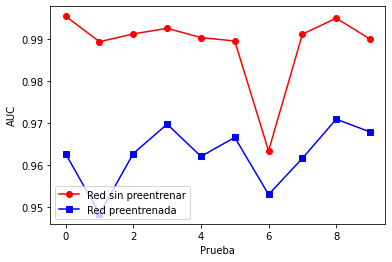

In [27]:
print(cv_auc0)
print(cv_auc1)
plt.plot(range(len(cv_auc0)),cv_auc0,'ro-',label='Red sin preentrenar')
plt.plot(range(len(cv_auc1)),cv_auc1,'bs-',label='Red preentrenada')
plt.ylabel('AUC')
plt.xlabel('Prueba')
plt.legend()

wilcox_V, p_value =  wilcoxon(cv_auc1, cv_auc0, alternative='greater', zero_method='wilcox', correction=False)

print('Resultado completo del test de Wilcoxon')
print(f'Wilcox V: {wilcox_V}, p-value: {p_value:.2f}')

In [ ]:
'''epochs = 500

cvscores=[]
y_cvscores=[]
cvy_test=[]
cvy_train=[]
i=0

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

for train_index,test_index in skf.split(X,y):#nuevo
#for train_index,test_index in skf.split(train_generator):#nuevo
  print(f'Folder: {i}')
  i+=1
  model = cnn_model()

  X_train,X_test=X[train_index],X[test_index]#nuevo Falta cambiar
  y_train_nn,y_test_nn=y[train_index],y[test_index]#nuevo Falta cambiar
  y_train,y_test=y[train_index],y[test_index] #Falta cambiar

  data_augmented=data_augmentation(X_train,y_train_nn,32) #Aumentado de datos

  cvy_test.append(y_test)
  cvy_train.append(y_train)

  model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
  history=model.fit(data_augmented, batch_size=BATCH_SIZE, epochs=epochs, validation_data=(X_test,y_test_nn), verbose=2, callbacks=[early_stopping]) #Aumentado de datos


  scores =model.evaluate(X_test,y_test_nn,verbose=0)
  y_scores=model.predict(X_test) # Confidence prediction per class
  cvscores.append(scores)
  y_cvscores.append(y_scores)
  #print("%s: %.2f%%"%(model.metrics_names[1],scores[1]*100))
  #Borrar:
  #if i==2:
  #  break

print(model.summary())'''

Folder: 0
Epoch 1/500
119/119 - 8s - loss: 0.5059 - accuracy: 0.7996 - val_loss: 0.3985 - val_accuracy: 0.8656 - 8s/epoch - 68ms/step
Epoch 2/500
119/119 - 3s - loss: 0.4084 - accuracy: 0.8371 - val_loss: 0.3406 - val_accuracy: 0.8726 - 3s/epoch - 21ms/step
Epoch 3/500
119/119 - 3s - loss: 0.3721 - accuracy: 0.8508 - val_loss: 0.3132 - val_accuracy: 0.8797 - 3s/epoch - 21ms/step
Epoch 4/500
119/119 - 3s - loss: 0.3663 - accuracy: 0.8487 - val_loss: 0.3065 - val_accuracy: 0.8726 - 3s/epoch - 22ms/step
Epoch 5/500
119/119 - 3s - loss: 0.3488 - accuracy: 0.8603 - val_loss: 0.2906 - val_accuracy: 0.8821 - 3s/epoch - 21ms/step
Epoch 6/500
119/119 - 3s - loss: 0.3448 - accuracy: 0.8600 - val_loss: 0.2866 - val_accuracy: 0.8797 - 3s/epoch - 21ms/step
Epoch 7/500
119/119 - 2s - loss: 0.3347 - accuracy: 0.8666 - val_loss: 0.2824 - val_accuracy: 0.8797 - 2s/epoch - 21ms/step
Epoch 8/500
119/119 - 3s - loss: 0.3404 - accuracy: 0.8597 - val_loss: 0.2751 - val_accuracy: 0.8868 - 3s/epoch - 21ms/ste

In [ ]:
'''acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(epochs)
epochs_range = range(len(loss))

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.savefig('./foo.png')
plt.show()'''

In [ ]:
'''cv_auc3=[]
auc3=0
#y_cvscores = predicciones
#cvy_test = soluciones

for i in range(len(y_cvscores)):
  y_pred = y_cvscores[i].argmax(axis=1) # Select classes with most confidence prediction
  auc_i=metrics.roc_auc_score(cvy_test[i], np.round(y_cvscores[i][:,0],2))
  auc3+=auc_i

  cv_auc3.append(auc_i)

auc3/=len(cv_auc3)
print(cv_auc3)
print(f'AUC {auc3:.4f} ')'''

In [ ]:
'''print(cv_auc0)
print(cv_auc3)
plt.plot(range(len(cv_auc0)),cv_auc0,'ro-',label='Red preentrenada')
plt.plot(range(len(cv_auc3)),cv_auc3,'bs-',label='Red sin preentrenar')
plt.ylabel('AUC')
plt.xlabel('Prueba')
plt.legend()'''